In [1]:
!pip install tqdm==4.28.1
!pip install -U gast==0.2.2
!pip install gdown

!gdown https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
!mkdir datasets
!tar -C datasets -xzf airport-alunos.tgz


Requirement already up-to-date: gast==0.2.2 in /opt/anaconda3/envs/siamesas/lib/python3.7/site-packages (0.2.2)
Downloading...
From: https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
To: /home/joao/Documents/Doutorado/ammd2-siamesas/airport-alunos.tgz
533MB [01:54, 4.67MB/s] 
mkdir: cannot create directory ‘datasets’: File exists


In [1]:
#%tensorflow_version 2.x
import tensorflow as tf; print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import numpy as np
import tqdm; print(tqdm.__version__)
import matplotlib.pyplot as plt
%matplotlib inline

2.0.0
4.28.1


In [2]:
def base_model(input_shape):
    """
        Model architecture
    """
    
    input_layer = Input(shape = input_shape)
    
    seq_model = Conv2D(8, (3, 3), activation = 'relu')(input_layer)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Conv2D(16, (3, 3), strides = (2, 2), padding = 'same')(seq_model)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Conv2D(32, (3, 3), strides = (2, 2), padding = 'same')(seq_model)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Conv2D(64, (3, 3), strides = (2, 2), padding = 'same')(seq_model)
    seq_model = BatchNormalization()(seq_model)
    seq_model = Activation('relu')(seq_model)
    seq_model = MaxPooling2D((2, 2), padding = 'same')(seq_model)
    
    seq_model = Flatten()(seq_model)
    seq_model = Dense(64)(seq_model)
    
    seq_model = Model(inputs=input_layer, outputs=seq_model)
    
    return seq_model
  
def siamise_model(input_shape):
    
    seq_model = base_model(input_shape)
    
    left_input = Input(shape = input_shape)
    right_input = Input(shape = input_shape)
    
    left_encod = seq_model(left_input)
    right_encod = seq_model(right_input)

    lambda_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    lambda_distance  = lambda_layer([left_encod, right_encod])
    
    return Model(inputs=[left_input,right_input], outputs=lambda_distance)

In [3]:
file_names_treino = !find datasets/airport-alunos/treino -name '???.png' | sort
file_names_val = !find datasets/airport-alunos/val -name '???.png' | sort

print(file_names_treino[:2])
print(file_names_val[:2])

['datasets/airport-alunos/treino/0/000/000.png', 'datasets/airport-alunos/treino/0/000/001.png']
['datasets/airport-alunos/val/0/200/000.png', 'datasets/airport-alunos/val/0/200/001.png']


In [4]:
#load_sample_image('datasets/airport-alunos/treino/0/094/051.png')

#tf.image.decode_image(tf.io.read_file('datasets/airport-alunos/treino/0/094/051.png'))

In [5]:
from dataset_utils import person_to_img
from dataset_utils import combine_cam_files
from dataset_utils import get_batch
from dataset_utils import plot_sample

# carrega imagens para memória
cam_img_dict_treino, pids1_treino, pids2_treino = person_to_img(file_names_treino)
cam_img_dict_val, pids1_val, pids2_val = person_to_img(file_names_val)

Images in cam1 = 14094, cam2 = 14939
Images in cam1 = 2824, cam2 = 3648


In [6]:
# gera listas de similares e dissimilares na memória
d_combination_treino = combine_cam_files(pids1_treino, pids2_treino)
d_combination_val = combine_cam_files(pids1_val, pids2_val)

100%|██████████| 2824/2824 [00:00<00:00, 2982.30it/s]


In [7]:
# obtem pares de batches apartir das imagens em memória
X_a_treino, X_b_treino, y_treino = get_batch(d_combination_treino, cam_img_dict_treino)
X_a_val, X_b_val, y_val = get_batch(d_combination_val, cam_img_dict_val)

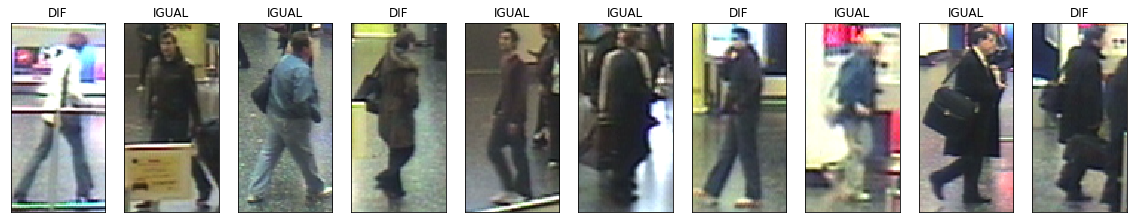

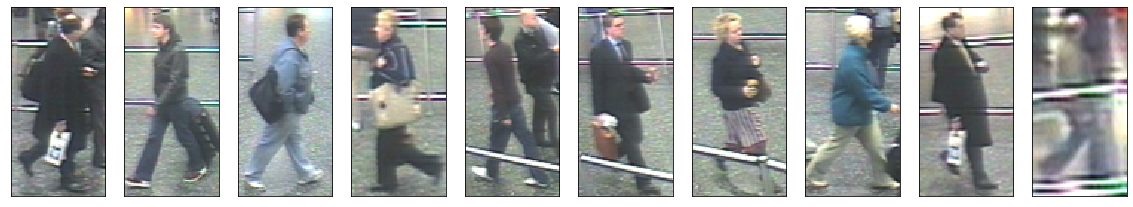

In [8]:
plot_sample(X_a_treino/255, X_b_treino/255, y_treino)

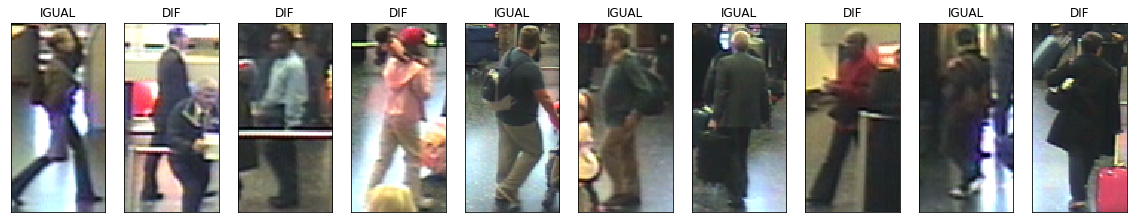

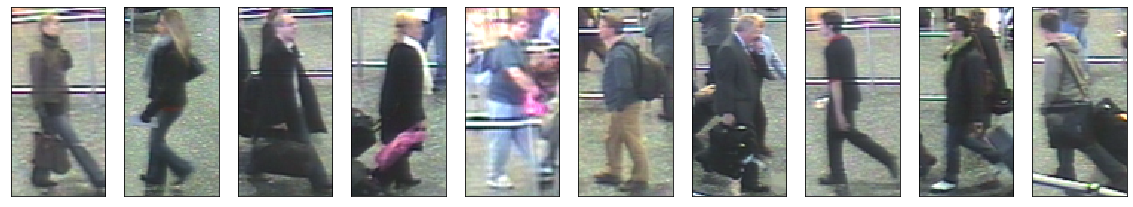

In [9]:
plot_sample(X_a_val/255, X_b_val/255, y_val)

In [10]:
import random
def get_batch(d_combination, cam_img_dict):
    def pairs_labels():
        i = 0        
        for key, value in d_combination.items():
            if i % 2 == 0:
                t = ((0, *key), (1, *random.choice(value)), 1.)
            else:
                t = ((0, *key), (1, *random.choice(value)), 0.)
            i += 1
            yield t
            
    train_data = list(pairs_labels())
    return train_data
train_data = get_batch(d_combination_treino, cam_img_dict_treino)

In [11]:
train_data[:10]

[((0, 157, 102), (1, 157, 70), 1.0),
 ((0, 53, 53), (1, 146, 24), 0.0),
 ((0, 39, 70), (1, 39, 13), 1.0),
 ((0, 114, 5), (1, 103, 49), 0.0),
 ((0, 167, 13), (1, 167, 59), 1.0),
 ((0, 43, 3), (1, 70, 31), 0.0),
 ((0, 29, 44), (1, 29, 6), 1.0),
 ((0, 67, 137), (1, 19, 101), 0.0),
 ((0, 157, 23), (1, 157, 75), 1.0),
 ((0, 90, 42), (1, 124, 66), 0.0)]

In [12]:
import numpy as np
X_a_train = np.array([cam_img_dict_treino[x[0]] for x in train_data[:10]], dtype = np.float32)

In [13]:
[x[0] for x in train_data[:1]]
# (0, 157, 102)[0]

[(0, 157, 102)]

In [14]:
cam_img_dict_treino[(0, 157, 102)]

array([[[243, 244, 180],
        [238, 241, 169],
        [238, 244, 158],
        ...,
        [ 51,  99, 101],
        [102, 158, 157],
        [162, 217, 217]],

       [[240, 242, 181],
        [244, 243, 172],
        [239, 241, 157],
        ...,
        [ 68, 117, 125],
        [119, 171, 178],
        [178, 233, 240]],

       [[236, 238, 177],
        [243, 243, 172],
        [239, 242, 158],
        ...,
        [ 94, 146, 161],
        [134, 187, 205],
        [204, 254, 254]],

       ...,

       [[255, 255, 194],
        [255, 255, 192],
        [255, 255, 190],
        ...,
        [186, 214, 192],
        [190, 218, 197],
        [188, 215, 197]],

       [[174, 194,  97],
        [182, 200,  97],
        [199, 214, 105],
        ...,
        [179, 209, 187],
        [185, 214, 195],
        [185, 214, 195]],

       [[ 91, 114,  32],
        [105, 124,  38],
        [127, 145,  52],
        ...,
        [175, 210, 186],
        [181, 214, 194],
        [181, 214, 194]]

In [15]:
def load_img(image_file):
    return tf.io.read_file(image_file)

def img_to_array(image_raw):
    return tf.image.decode_image(image_raw)

img_to_array(load_img('datasets/airport-alunos/treino/0/000/000.png')).numpy()

array([[[109,  63,  60],
        [111,  71,  64],
        [107,  71,  63],
        ...,
        [ 78,  59,  51],
        [ 69,  50,  43],
        [ 82,  65,  57]],

       [[ 98,  65,  58],
        [102,  74,  63],
        [101,  74,  63],
        ...,
        [ 75,  56,  47],
        [ 68,  50,  41],
        [ 83,  66,  56]],

       [[ 95,  70,  60],
        [ 97,  74,  62],
        [ 95,  74,  61],
        ...,
        [ 76,  54,  48],
        [ 72,  51,  46],
        [ 87,  68,  60]],

       ...,

       [[ 74,  73,  65],
        [ 63,  63,  54],
        [ 63,  63,  54],
        ...,
        [137, 144, 149],
        [138, 145, 148],
        [140, 146, 149]],

       [[ 70,  69,  61],
        [ 63,  60,  53],
        [ 63,  60,  53],
        ...,
        [140, 146, 151],
        [141, 147, 153],
        [142, 148, 154]],

       [[ 69,  67,  59],
        [ 64,  61,  54],
        [ 63,  60,  53],
        ...,
        [141, 147, 153],
        [142, 148, 154],
        [143, 149, 155]]